
**Topics**
- NLP Pre-processing Data
- Text Classification
 + Word2Vec
 + LSTM
 + BERT (Transformer - Keras)
 + BERT (Transformer - Pytorch)
 + BERT (Transformer - Simple Transformer)

# Text Classification

## Preparing VM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Feb 14 08:47:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
# Command line tool for monitoring VM
! apt-get -qq install htop -y

Selecting previously unselected package htop.
(Reading database ... 155113 files and directories currently installed.)
Preparing to unpack .../htop_2.1.0-3_amd64.deb ...
Unpacking htop (2.1.0-3) ...
Setting up htop (2.1.0-3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for mime-support (3.60ubuntu1) ...


## Pre-processing

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/wongnai/wongnai-corpus.git

Cloning into 'wongnai-corpus'...
remote: Enumerating objects: 127, done.
remote: Total 127 (delta 0), reused 0 (delta 0), pack-reused 127
Receiving objects: 100% (127/127), 39.65 MiB | 40.32 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [ ]:
os.chdir('wongnai-corpus/review')

In [ ]:
!unzip review_dataset.zip

Archive:  review_dataset.zip
 extracting: sample_submission.csv   
  inflating: test_file.csv           
  inflating: w_review_train.csv      
   creating: __MACOSX/
  inflating: __MACOSX/._sample_submission.csv  
  inflating: __MACOSX/._test_file.csv  
  inflating: __MACOSX/._w_review_train.csv  


In [ ]:
!ls

__MACOSX	    sample_submission.csv  w_review_train.csv
review_dataset.zip  test_file.csv


In [ ]:
!pwd

/content/wongnai-corpus/review


In [ ]:
!head -n 10 /content/wongnai-corpus/review/w_review_train.csv

"ร้านอาหารใหญ่มากกกกกกก 
เลี้ยวเข้ามาเจอห้องน้ำก่อนเลย เออแปลกดี 
ห้องทานหลักๆอยู่ชั้น 2 มีกาแฟ น้ำผึ้ง ซึ่งก็แค่เอาน้ำผึ้งมาราด แพงเวอร์ อย่าสั่งเลย 
ลาบไข่ต้ม ไข่มันคาวอะ เลยไม่ประทับใจเท่าไหร่
ทอดมันหัวปลีกรอบอร่อยต้องเบิ้ล 
พะแนงห่อไข่อร่อยดี เห้ยแต่ราคา 150บาทมันเกินไปนะ รับไม่ไหวว
เลิกกินแล้วมีขนมหวานให้กินฟรีเล็กน้อย )ขนมไทย) 

คงไม่ไปซ้ำ แพงเกิน ";3
"อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา ตัวร้านตั้งอยู่ที่ถนนพุทธมณฑลสาย 3 ไปตาม ถ.ปิ่นเกล้า-นครชัยศรี เมื่อถึงพุทธมณฑลสาย 3 ก็เลี้ยวเข้าไปประมาณ 500 เมตร ร้านอยู่ทางซ้ายมือค่ะ มีคนบอกมาว่าความพิเศษของร้านนี้คือกุ๊กเก่าและเป็นกุ๊กรุ่นสุดท้ายจาก ""ฮก ลก ซิ่ว” ภัตตาคารจีนชื่อดังย่านราชประสงค์ ที่เลิกกิจการไปแล้ว ต้องคนที่อายุเลข 5 ขึ้นไปจึงจะเคยกิน ฮก ลก ซิ่ว  จานเด็ดที่มีขายที่นี่แห่งเดียวในเมืองไทยคือ ปลาเต๋าเต้ย 2 ฤดู เป็นสูตรจากมาเลเซีย นอกนั้นก็มี ผัดผักน้ำมันหอย ไก่เบตง เคาหยก ปูทะเลซุปน้ำใสหม้อไฟ เต้าหู้แคระยัดไส้หม้อดิน และ ลูกชิ้นแคระ 


In [ ]:
def create_data(file_path, test_size=0.1):
  '''
  Split wongnai training data into train and test set and save them in new folder called "wongnai_data"

  Arguments:
  file_path -- data file to be split.
  test_size -- proportion of the test split. Float between 0-1.

  Returns:
  train -- DataFrame of training data.
  test -- DataFrame of test data.
  '''

  # Preprocess data with csv that does not have header
  data = pd.read_csv(file_path, sep=';', names=['review', 'star'])

  # Split data with stratification to avoid class imbalance
  x = data[['review']]
  y = data[['star']]
  x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=test_size, random_state=42)

  train = x_train.join(y_train)
  test = x_test.join(y_test)

  # Save to csv files
  try:
    os.mkdir('wongnai_data')
  except:
    print('Folder already exists, proceed to saving.')
  train.to_csv('wongnai_data/train.csv', index=False) # , header=False)
  test.to_csv('wongnai_data/test.csv', index=False) # , header=False)

  return train, test

In [ ]:
train, test = create_data('/content/wongnai-corpus/review/w_review_train.csv')

In [ ]:
train

,review,star
8925,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...,3
4802,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...,4
24339,อูมิ (Umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...,5
34701,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...,5
31990,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...,5
...,...,...
27946,ร้านก๋วยเตี๋ยวหมูตุ๋นเจ้าเก่าดั้งเดิม ด้วยประส...,4
27687,คะแนนรวมร้าน⭐️⭐️\nบริการ⭐️⭐️\nรสชาติ⭐️⭐️\nราคา...,2
4502,ร้านขนมข้าวกาแฟ บรรยากาศสบายๆมีน้องหมามาตอนรับ...,3
31182,ร้านตั้งอยู่ริมถนน ถึงก่อนหมูบ้านสารินคับ ที่จ...,3


In [ ]:
test

,review,star
17140,ร้านเก่า อร่อย ราคาเบาๆ \nชอบเนื้อร้านนี้อร่อย...,4
26008,ใกล้ที่พักเลยลองเดินมาชิม \n- โจ๊กอร่อยนะ 25 บ...,4
1021,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,4
22522,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,3
6108,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,1
...,...,...
1930,ซูชิสายพาน สาขาสยามพารากอน ชั้น 4 แน่นอนว่าเลื...,4
14278,ร้านนี้กินบ่อย กินมานานมากกกก\nชอบอะไร ชอบหมูต...,4
14748,ได้ยินชื่อเสียงร้านนี้จากเพื่อนๆ มานาน แต่ก็ยั...,4
33025,ร้านสมัยแรกๆที่เปิดตัวมาพร้อม I'm Park ช่วงเมน...,4


In [ ]:
# Reduce data size for faster executions.
train = train[:5000]
test = test[:1000]

In [ ]:
train

,review,star
8925,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...,3
4802,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...,4
24339,อูมิ (Umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...,5
34701,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...,5
31990,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...,5
...,...,...
15795,ถ้าพูดถึงร้านกาแฟในเชียงใหม่แล้วคงมีสักระดับพั...,5
28604,รีวิวช้าไปหน่อย จริงๆมากินวันวาเลนไทน์ อยากบอก...,4
20348,ร้านเชสเตอร์กริล สาขาขนส่งสายใต้ใหม่ เดินทางกร...,3
7953,ทานชาเขียวกีวี่+ไข่มุกเป็นประจำค่ะ \nทานกี่สาข...,5


In [ ]:
test

,review,star
17140,ร้านเก่า อร่อย ราคาเบาๆ \nชอบเนื้อร้านนี้อร่อย...,4
26008,ใกล้ที่พักเลยลองเดินมาชิม \n- โจ๊กอร่อยนะ 25 บ...,4
1021,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,4
22522,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,3
6108,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,1
...,...,...
462,ร้านอาหารทะเลแบบพื้นๆม่ีไม่มีอะไรมากมายในการตก...,5
3379,สวัสดีค่าาาา\nคราวนี้บีจะมารีวิวร้านอาหาร sush...,4
8177,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,3
20896,Quip sky bar roof top แห่งแรกบนภูเก็ตครับ\nเป็...,4


### Data Distribution & Up Sampling using SMOTE

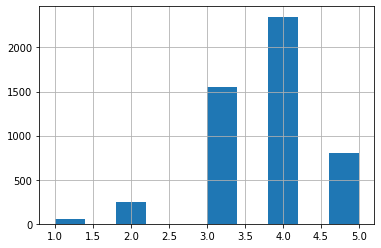

In [ ]:
train["star"].hist()

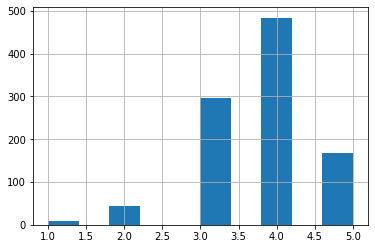

In [ ]:
test["star"].hist()

In [ ]:
# Up sampling & Down sampling of text data using SMOTE
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer

sm = SMOTE(random_state = 2)
lb = LabelBinarizer()

# Waiting for 1 min and consume high memory
# If you not in Colab Pro, it will failed due to not enough memory:
# may be resize the size of training down to just see how it works
# e.g., train_balance = train[:1000]

X_train = lb.fit_transform(train["review"])
X_train_bin, y = sm.fit_resample(X_train, train["star"])
X = lb.inverse_transform(X_train_bin)

In [ ]:
X

array(['ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลายแบบให้เลือกกิน สำหรับตนกลัวอ้วนผมไม่แนะนำนะครับ อ้วนแน่ๆ ฮิฮิ แต่ตามที่บอกเคกน่ากินแต่ราคาอาจจะแพงนิดนึง ไม่ดิค่อนข้างแพงถ้าเทียบกับร้านอื่น จริงๆ ผมดูมสแล้ว แต่ก็อร่อยพอตัว ทางร้านเลยมั่นใจที่จะขายราคาแพงนิดนึง ผมว่านะ ไม่รู้จริงหรือเปล่า',
       'ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ริมถนนหน้าร้าน \nการบริการที่นี่ โอเคค่ะ เหมือนร้านทั่วไป\nเมนูที่สั่งคราวนี้\n-ปลาผัดพริกขิง จานนี้อร่อย ปลาทอดแยกกับถั่วฝักยาวผัดเครื่องแกง จึงทำให้ไม่นิ่มไม่แฉะ รสชาติเผ็ดเค็มถึงรสมากค่ะ\n-ออเดิฟเมืองน้ำพริกหนุ่ม น้ำพริกหนุ่มที่นี่อร่อยมากค่ะ ไม่เผ็ดทำให้ทานได้เรื่อยๆ ในเซทจะมีผักต้ม ไข่ต้ม แหนม แคบหมู หมูทอด ไส้อั่วค่ะ\n-ปลาทอดยำมะม่วง ปลาช่อนทอดมากำลังดีไม่แข็ง ไม่มีกลิ่น น้ำยำครบรสดีค่ะ อร่อยค่ะ\n-เห็ดหอมตุ๋นซี่โครงหมู เมนูนี้เฉยๆค่ะ\n',
       'อูมิ (Umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอยทองหล่อ 13 (โครงการพิมาน 49) ซอยที่เต็มไปด้วยร้านอาหารหลากหลายสัญชาติ ความโดดเด่นของอูมิ อยู่ตรงที่ร้านนี้เป็นร้านอาหารญี่ปุ่นสไตล์โอมากะเสะ (Omakas

In [ ]:
y

0        3
1        4
2        5
3        5
4        5
        ..
11740    5
11741    5
11742    5
11743    5
11744    5
Name: star, Length: 11745, dtype: int64

In [ ]:
import pandas as pd
train_bal = pd.DataFrame({'review': X, 'star': y})

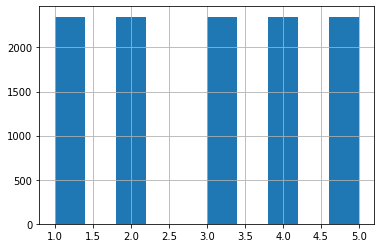

In [ ]:
train_bal['star'].hist()

In [ ]:
# Making decision using either the balanced dataset or the original dataset
train = train_bal

#### Cleaning Data

In [ ]:
# Remove all HTML tag
a = data['b'].str.replace(r'<[^<>]*>', '', regex=True)
test['clean_review'] = test['review'].str.replace(r'<[^<>]*>', '', regex=True)

# Remove all excessive space, special characters and new line symbols
train['clean2_review'] = train['clean_review'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')
test['clean2_review'] = test['clean_review'].str.strip().str.lower().str.replace('\r+', ' ').str.replace('\n+',' ').str.replace('\t+',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [ ]:
#Remove emoji
import re

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

train['clean3_review'] = train.apply(lambda row: deEmojify(row['clean2_review']), axis=1)
test['clean3_review'] = test.apply(lambda row: deEmojify(row['clean2_review']), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train

,review,star,clean_review,clean2_review,clean3_review
0,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...,3,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...,ตามที่บอกเป็นร้านกาแฟที่เน้นขายเคกนะครับ มีหลา...
1,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...,4,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...,ร้านนี้อยู่ก่อนถึงถนนคนเดินค่ะ สามารถจอดรถได้ร...
2,อูมิ (Umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...,5,อูมิ (Umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...,อูมิ (umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...,อูมิ (umi) คืออีกหนึ่งร้านซูชิที่ตั้งอยู่ในซอย...
3,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...,5,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...,ร้านนี้มีสโลแกน ปลูกผักเพราะรักแม่ ดังนั้นช่วง...
4,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...,5,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...,มาตามลายแทง เห็นร้านและการแต่งก็ตัดสินใจเลย ร้...
...,...,...,...,...,...
11740,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,5,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...
11741,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,5,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...
11742,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,5,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...
11743,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,5,\n\n\n\n\nร้าน Dakasi เป็นร้านเครื่องดื่มครับ ...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...,ร้าน dakasi เป็นร้านเครื่องดื่มครับ มีหลายสาขา...


### Text Normalization / Word Segmentation / Stop words filtering

In [ ]:
! pip -q install pythainlp python-crfsuite

     |████████████████████████████████| 11.5 MB 5.2 MB/s 
     |████████████████████████████████| 743 kB 92.5 MB/s 


In [ ]:
from pythainlp.util import normalize
from pythainlp.corpus import thai_stopwords
from pythainlp.tokenize import word_tokenize

stopwords = list(thai_stopwords())
stopwords.append("nan")
stopwords.append("-")
stopwords.append("_")
stopwords.append("")
stopwords.append(" ")

# Normalize text
train['clean4_review'] = train.apply(lambda row: normalize(row['clean3_review']), axis=1)
test['clean4_review'] = test.apply(lambda row: normalize(row['clean3_review']), axis=1)

# Word segmentation: it will take a while....
train['wordseged_review'] = train.apply(lambda row: word_tokenize(row['clean4_review'],engine="newmm-safe"), axis=1)
test['wordseged_review'] = test.apply(lambda row: word_tokenize(row['clean4_review'],engine="newmm-safe"), axis=1)

# Remove stopwords, it will take a very long time..... 
# train['wordseged_nostopword_review'] = train.apply(lambda row: [i for i in train['wordseged_review'] if i not in stopwords], axis=1)
# test['wordseged_nostopword_review'] = test.apply(lambda row: [i for i in test['wordseged_review'] if i not in stopwords], axis=1)

# Join the wordsegged with space
train['wordseged_space_review'] = train.apply(lambda row: " ".join(row["wordseged_review"]), axis=1)
test['wordseged_space_review'] = test.apply(lambda row: " ".join(row["wordseged_review"]), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
test

,review,star,clean_review,clean2_review,clean3_review,clean4_review,wordseged_review,wordseged_space_review
17140,ร้านเก่า อร่อย ราคาเบาๆ \nชอบเนื้อร้านนี้อร่อย...,4,ร้านเก่า อร่อย ราคาเบาๆ \nชอบเนื้อร้านนี้อร่อย...,ร้านเก่า อร่อย ราคาเบาๆ ชอบเนื้อร้านนี้อร่อยม...,ร้านเก่า อร่อย ราคาเบาๆ ชอบเนื้อร้านนี้อร่อยม...,ร้านเก่า อร่อย ราคาเบาๆ ชอบเนื้อร้านนี้อร่อยมา...,"[ร้าน, เก่า, , อร่อย, , ราคา, เบา, ๆ, , ชอบ...",ร้าน เก่า อร่อย ราคา เบา ๆ ชอบ เนื้อ ร้า...
26008,ใกล้ที่พักเลยลองเดินมาชิม \n- โจ๊กอร่อยนะ 25 บ...,4,ใกล้ที่พักเลยลองเดินมาชิม \n- โจ๊กอร่อยนะ 25 บ...,ใกล้ที่พักเลยลองเดินมาชิม - โจ๊กอร่อยนะ 25 บา...,ใกล้ที่พักเลยลองเดินมาชิม - โจ๊กอร่อยนะ 25 บา...,ใกล้ที่พักเลยลองเดินมาชิม - โจ๊กอร่อยนะ 25 บาท...,"[ใกล้, ที่พัก, เลย, ลอง, เดิน, มา, ชิม, , -, ...",ใกล้ ที่พัก เลย ลอง เดิน มา ชิม - โจ๊ก อร่...
1021,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,4,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,ร้านอาหารครัวพวงพยอมอยู่บนเกาะล้าน พัทยา จ.ชลบ...,"[ร, ้าน, อาหาร, ครัว, พวง, พยอม, อยู่, บน, เกา...",ร ้าน อาหาร ครัว พวง พยอม อยู่ บน เกาะ ล้าน ...
22522,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,3,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,ร้านนี้ญาติชวนมาเลี้ยงวันเกิด บอกว่าบรรยากาศดี...,"[ร้าน, นี้, ญาติ, ชวน, มา, เลี้ยง, วันเกิด, ,...",ร้าน นี้ ญาติ ชวน มา เลี้ยง วันเกิด บอ กว่า ...
6108,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,1,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,ชาบูราคา299 มีหมูสไลด์ เนื้อสไลด์ ของกินเล่นไข...,"[ชาบู, ราคา, 299, , มี, หมู, สไลด์, , เนื้อ,...",ชาบู ราคา 299 มี หมู สไลด์ เนื้อ สไลด์ ข...
...,...,...,...,...,...,...,...,...
462,ร้านอาหารทะเลแบบพื้นๆม่ีไม่มีอะไรมากมายในการตก...,5,ร้านอาหารทะเลแบบพื้นๆม่ีไม่มีอะไรมากมายในการตก...,ร้านอาหารทะเลแบบพื้นๆม่ีไม่มีอะไรมากมายในการตก...,ร้านอาหารทะเลแบบพื้นๆม่ีไม่มีอะไรมากมายในการตก...,ร้านอาหารทะเลแบบพื้นๆมี่ไม่มีอะไรมากมายในการตก...,"[ร้าน, อาหารทะเล, แบบ, พื้นๆ, มี่, ไม่, มี, อะ...",ร้าน อาหารทะเล แบบ พื้นๆ มี่ ไม่ มี อะไร มากมา...
3379,สวัสดีค่าาาา\nคราวนี้บีจะมารีวิวร้านอาหาร sush...,4,สวัสดีค่าาาา\nคราวนี้บีจะมารีวิวร้านอาหาร sush...,สวัสดีค่าาาา คราวนี้บีจะมารีวิวร้านอาหาร sushi...,สวัสดีค่าาาา คราวนี้บีจะมารีวิวร้านอาหาร sushi...,สวัสดีค่า คราวนี้บีจะมารีวิวร้านอาหาร sushi ให...,"[สวัสดี, ค่า, , คราวนี้, บี, จะ, มา, รีวิว, ร...",สวัสดี ค่า คราวนี้ บี จะ มา รีวิว ร้านอาหาร ...
8177,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,3,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,ร้านกาแฟร้านนี้ ถ้าใคนได้แวะเวียนไปที่สวนผึ้ง ...,"[ร้านกาแฟ, ร้าน, นี้, , ถ้า, ใคน, ได้, แวะเวี...",ร้านกาแฟ ร้าน นี้ ถ้า ใคน ได้ แวะเวียน ไป ที...
20896,Quip sky bar roof top แห่งแรกบนภูเก็ตครับ\nเป็...,4,Quip sky bar roof top แห่งแรกบนภูเก็ตครับ\nเป็...,quip sky bar roof top แห่งแรกบนภูเก็ตครับ เป็น...,quip sky bar roof top แห่งแรกบนภูเก็ตครับ เป็น...,quip sky bar roof top แห่งแรกบนภูเก็ตครับ เป็น...,"[quip, , sky, , bar, , ro, of, , top, , แ...",quip sky bar ro of top แห่ง แรก บน ภ...


## Word2Vec

In [ ]:
!pip install pythainlp python-crfsuite

In [ ]:
from pythainlp import word_vector
import numpy as np
word2vec = word_vector.get_model()

Corpus: thai2fit_wv
- Downloading: thai2fit_wv 0.1


100%|██████████| 62452646/62452646 [00:00<00:00, 220393866.16it/s]


In [ ]:
def get_average_vector(cleaned_query):
    sum_query = None
    count=0
    for query in cleaned_query:
        try:
            if (sum_query is None):
                sum_query = np.copy(word2vec[query])
            else:
                sum_query += word2vec[query]
            count+=1
            print("Word "+query+ " found!")
        except:
            print("Word "+query+" is not found!")
    if (sum_query is not None):
        average_query = sum_query/count
    else:
        average_query = np.zeros((300,))
    return average_query

average_query = get_average_vector(["ทดสอบ","ดู","นะ","ครับ"])
print(average_query)

Word ทดสอบ found!
Word ดู found!
Word นะ found!
Word ครับ found!
[ 0.0729435   0.10315551  0.09200675  0.20117874  0.0884465  -0.02690875
 -0.19606349  0.1138515  -0.142324    0.1712055  -0.02833    -0.08175799
 -0.0646225   0.13941674 -0.00328775 -0.21250674  0.11129924  0.08854325
  0.10727476 -0.31458575 -0.01692325 -0.08343    -0.027316    0.2538085
 -0.17720951 -0.09206425 -0.1467155   0.07075325 -0.1685635   0.007884
  0.187906   -0.265904   -0.01858099  0.03022575 -0.1081155   0.11422776
  0.15058425  0.06027399  0.12092424  0.08924175 -0.01036475 -0.208514
  0.1412115   0.004442   -0.17056376 -0.18328774 -0.02664525 -0.316675
 -0.07512475  0.0436375  -0.08636225  0.02774225  0.01774126 -0.19483599
  0.0950405   0.18499452  0.015365   -0.099916    0.1140205  -0.11109875
  0.0566305  -0.07291149 -0.01777725 -0.2032655   0.05336475 -0.235581
 -0.1757015   0.1420705   0.18264925 -0.2221965   0.058705    0.20701227
  0.18176325 -0.40199196  0.247788    0.05174225  0.12133725  0.1273

In [ ]:
from functools import reduce

# Make average vectors of each class
avg_w = {}
for i in range(1,6):
  avg_w[i] = reduce(lambda x,y: x+y, train[train["star"]==i][:100]['wordseged_review'])

In [ ]:
avg_v = {}
for i in range(1,6):
  print(i, len(avg_w[i]))
  avg_v[i] = get_average_vector(avg_w[i])

Streaming output truncated to the last 5000 lines.
Word สั่งอาหาร is not found!
Word มา found!
Word 2 found!
Word เมนู found!
Word   is not found!
Word คือ found!
Word เสต็ก is not found!
Word ซี่โครง found!
Word กับ found!
Word สลัดผลไม้ is not found!
Word ที่ found!
Word คนแนะนำ found!
Word กัน found!
Word มา found!
Word เยอะ found!
Word   is not found!
Word สลัดผลไม้ is not found!
Word ก้อ found!
Word โอเค found!
Word   is not found!
Word แต่ found!
Word น้ำสลัด is not found!
Word เฉย found!
Word ๆไ is not found!
Word ป found!
Word นิด found!
Word เหมือน found!
Word ที่ found!
Word บาง found!
Word รีวิว is not found!
Word กล่าว found!
Word   is not found!
Word ให้ found!
Word คะแนน found!
Word พ found!
Word รี found!
Word เซน found!
Word เต found!
Word ชั่น is not found!
Word   is not found!
Word :) found!
Word   is not found!
Word ส found!
Word ่วน is not found!
Word สเต็ก found!
Word ซี่โครง found!
Word   is not found!
Word ไป found!
Word 2 found!
Word คน found!
Word สั่ง found!
W

In [ ]:
def cosine_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
qv = get_average_vector(["อร่อย","ดี","มาก"])

Word อร่อย found!
Word ดี found!
Word มาก found!


In [ ]:
qv

array([ 0.4970347 ,  0.05305467,  0.036148  ,  0.01796567, -0.46168065,
        0.00477767, -0.35817334,  0.16688366, -0.05380833,  0.16617234,
       -0.17113167, -0.15540333, -0.19640465,  0.109874  ,  0.19812967,
        0.03842933, -0.32812166,  0.04498233, -0.10878333, -0.078063  ,
       -0.291491  ,  0.189939  ,  0.114712  ,  0.30603668,  0.37730268,
       -0.176153  , -0.18765832, -0.10702399, -0.43001565, -0.21257134,
       -0.01821033, -0.02056733, -0.28297433, -0.17606668,  0.34078065,
        0.04577266,  0.23175435,  0.49872804,  0.074815  , -0.29889134,
       -0.12646401,  0.26759365,  0.107553  , -0.29864833, -0.317023  ,
       -0.03760334,  0.011649  ,  0.04904266,  0.161366  , -0.012929  ,
       -0.39218   , -0.240803  ,  0.04298666, -0.06802233,  0.13819934,
        0.109747  ,  0.360665  ,  0.02696467,  0.11361533, -0.4347317 ,
       -0.056437  , -0.5344744 ,  0.10371601, -0.08545633, -0.02093   ,
       -0.016439  , -0.07689501, -0.02765633,  0.27549633,  0.07

In [ ]:
for i in range(1,6):
    print(i, cosine_sim(qv, avg_v[i]))

1 0.43716148
2 0.46639875
3 0.47404486
4 0.4823079
5 0.47881952


## LSTM

In [ ]:
! pip install pythainlp python-crfsuite

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(23)
from pythainlp import word_vector
import numpy as np
word2vec = word_vector.get_model()

In [ ]:
print("Vocab in Thai2Vec:",len(word2vec.wv.vocab))

Vocab in Thai2Vec: 51358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [ ]:
def sentences_to_indices(X, word2vec, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`.
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()[:max_len]
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word2vec:
              X_indices[i, j] = word2vec.wv.vocab[w].index
              # Increment j to j + 1
              j = j + 1
            
    return X_indices

In [ ]:
X1 = np.array(["สวัสดี ครับ ผม", "ทดสอบ ทดสอบ ทดสอบ", "เรา มา ทดสอบ กัน"])
X1_indices = sentences_to_indices(X1, word2vec, max_len = 10)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['สวัสดี ครับ ผม' 'ทดสอบ ทดสอบ ทดสอบ' 'เรา มา ทดสอบ กัน']
X1_indices = [[10966.  7412.  1478.     0.     0.     0.     0.     0.     0.     0.]
 [ 1481.  1481.  1481.     0.     0.     0.     0.     0.     0.     0.]
 [  512.    28.  1481.    67.     0.     0.     0.     0.     0.     0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
def convert_to_one_hot(y, maxLen):
    max_value = max(y)
    min_value = min(y)
    length = len(y)
    one_hot = np.zeros((length, (max_value - min_value + 1)))
    one_hot[np.arange(length), y] = 1
    return one_hot 

In [ ]:
def pretrained_embedding_layer(word2vec):
    """
    Creates a Keras Embedding() layer and loads in pre-trained PyThaiNLP word_vector 300-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word2vec.wv.vocab) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word2vec["สวัสดี"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word2vec.wv.vocab.items():
        # print(word)
        emb_matrix[index.index, :] = word2vec[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
embedding_layer = pretrained_embedding_layer(word2vec)
print("weights[0][1] =", embedding_layer.get_weights()[0][1])
# print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


weights[0][1] = [ 1.075100e-02 -6.189710e-01  1.296650e-01  3.546000e-02 -7.560000e-03
  2.760700e-02  3.978240e-01  2.654300e-02  2.540750e-01  1.683280e-01
 -9.858800e-02  2.570410e-01 -5.643300e-02  4.745000e-03 -1.944960e-01
 -9.463100e-02 -2.232210e-01  1.371390e-01 -7.294200e-02  2.684000e-03
 -7.887400e-02  1.081800e-02 -3.718210e-01  2.227020e-01 -1.310570e-01
 -1.781660e-01  7.801000e-03 -3.930770e-01  5.299490e-01 -3.101930e-01
  1.333700e-02 -1.813800e-02 -3.000430e-01 -5.032500e-02 -5.512390e-01
  2.832700e-01 -2.433820e-01  3.772650e-01  1.396830e-01  5.905610e-01
  2.934620e-01  2.302000e-03  2.777800e-01 -1.603492e+00 -6.830400e-02
 -6.939320e-01 -2.383000e-02  1.889580e-01 -1.672810e-01 -2.962500e-02
 -7.274390e-01 -6.587900e-02 -8.408900e-02  3.744550e-01  1.746500e-01
  1.294800e-02  3.895010e-01 -5.417900e-02 -4.989100e-02 -6.464240e-01
  1.128650e+00 -1.341001e+00 -2.358630e-01 -9.856200e-02 -5.247900e-02
 -4.950500e-02  3.165200e-02 -1.782880e-01 -1.089700e-02  4.8

In [ ]:
def text_clasifier_lstm(input_shape, word2vec):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)
    
    # Create the embedding layer pretrained with Word2Vec Vectors 
    embedding_layer =  pretrained_embedding_layer(word2vec)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.1
    X = Dropout(0.1)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128)(X)
    # Add dropout with a probability of 0.1
    X = Dropout(0.1)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(5, activation='softmax')(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)
    
    return model

In [ ]:
model = text_clasifier_lstm((128,), word2vec)
model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 128, 300)          15407700  
                                                                 
 lstm (LSTM)                 (None, 128, 128)          219648    
                                                                 
 dropout (Dropout)           (None, 128, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_indices = sentences_to_indices(train['wordseged_space_review'][:1000], word2vec, 128)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
Y_train_oh = convert_to_one_hot((train['star'][:1000]-1), 5)

In [ ]:
model.fit(X_train_indices, Y_train_oh, epochs = 10, batch_size = 32, shuffle=True)

Epoch 1/10
32/32 [==============================] - 8s 23ms/step - loss: 1.4387 - accuracy: 0.4690
Epoch 2/10
32/32 [==============================] - 1s 22ms/step - loss: 1.4213 - accuracy: 0.4830
Epoch 3/10
32/32 [==============================] - 1s 22ms/step - loss: 1.4237 - accuracy: 0.4800
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 1.4216 - accuracy: 0.4830
Epoch 5/10
32/32 [==============================] - 1s 22ms/step - loss: 1.4213 - accuracy: 0.4830
Epoch 6/10
32/32 [==============================] - 1s 21ms/step - loss: 1.4213 - accuracy: 0.4830
Epoch 7/10
32/32 [==============================] - 1s 21ms/step - loss: 1.4198 - accuracy: 0.4830
Epoch 8/10
32/32 [==============================] - 1s 22ms/step - loss: 1.4181 - accuracy: 0.4830
Epoch 9/10
32/32 [==============================] - 1s 21ms/step - loss: 1.4179 - accuracy: 0.4830
Epoch 10/10
32/32 [==============================] - 1s 21ms/step - loss: 1.4173 - accuracy: 0.4830


In [ ]:
preds = model.predict(X_train_indices[:10])
preds

array([[0.15155357, 0.15155391, 0.1633816 , 0.38193554, 0.15157546],
       [0.15153702, 0.1515374 , 0.16328023, 0.3820864 , 0.151559  ],
       [0.15155222, 0.15155256, 0.16337323, 0.38194793, 0.1515741 ],
       [0.15155356, 0.15155388, 0.16338155, 0.3819356 , 0.15157543],
       [0.15155342, 0.15155378, 0.16338094, 0.38193646, 0.15157531],
       [0.1515517 , 0.15155204, 0.16337003, 0.38195267, 0.15157358],
       [0.15155356, 0.1515539 , 0.16338164, 0.38193545, 0.15157545],
       [0.15155356, 0.1515539 , 0.16338162, 0.38193545, 0.15157545],
       [0.15155353, 0.15155388, 0.16338146, 0.38193575, 0.15157542],
       [0.15155222, 0.15155256, 0.16337335, 0.38194776, 0.15157412]],
      dtype=float32)

In [ ]:
np.argmax(preds, axis=1)+1

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

## BERT (via Transformers libary by Hugging Face)



### Bert-base-multilingual-cased (Tensorflow/Keras)

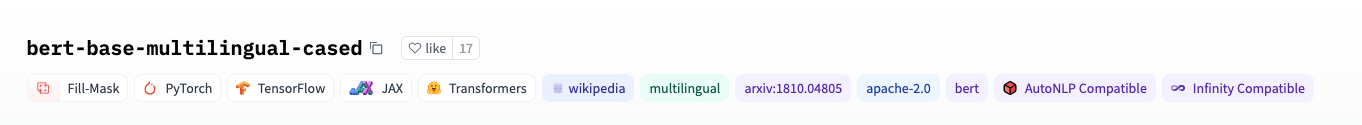

In [ ]:
! pip -q install datasets transformers[sentencepiece]

     |████████████████████████████████| 311 kB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 34.9 MB/s 
     |████████████████████████████████| 243 kB 61.2 MB/s 
     |████████████████████████████████| 1.1 MB 56.9 MB/s 
     |████████████████████████████████| 133 kB 57.1 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 271 kB 55.8 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 144 kB 59.0 MB/s 
     |████████████████████████████████| 6.8 MB 56.8 MB/s 
     |████████████████████████████████| 895 kB 57.6 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 1.2 MB 50.4 MB/s 


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
raw_datasets = load_dataset("wongnai_reviews")
# https://huggingface.co/datasets/wongnai_reviews

# If you interest in creating datasets on Transformer library
# see here >> https://github.com/huggingface/datasets/blob/54525e0443ebb2645969702bd8818bff49760435/datasets/wongnai_reviews/wongnai_reviews.py

Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672 [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wongnai_reviews downloaded and prepared to /root/.cache/huggingface/datasets/wongnai_reviews/default/1.0.1/0741f812b51dea635d957a5cc8f46fcc98828c0f6c557336ab20367778299a4d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review_body', 'star_rating'],
        num_rows: 6203
    })
})

In [ ]:
checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset["review_body"],
        [""]*len(dataset["review_body"]),
        max_length=128,
        truncation=True,
    )
    return encoded.data

tokenized_datasets = raw_datasets.map(tokenize_dataset, batched=True)

train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "token_type_ids"],
    label_cols=["star_rating"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32)

test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["input_ids", "attention_mask", "token_type_ids"],
    label_cols=["star_rating"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=32)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

checkpoint = 'bert-base-multilingual-cased'
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_39 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 177,857,285
Trainable params: 177,857,285
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    batch_size=32,
    verbose=1,
    epochs=1
)

1250/1250 [==============================] - 666s 513ms/step - loss: 1.2433 - accuracy: 0.4481 - val_loss: 1.2260 - val_accuracy: 0.3073


In [ ]:
r = next(iter(train_dataset))
r

({'attention_mask': <tf.Tensor: shape=(32, 128), dtype=int64, numpy=
  array([[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1]])>,
  'input_ids': <tf.Tensor: shape=(32, 128), dtype=int64, numpy=
  array([[  101,  1427, 43102, ..., 31256,   102,   102],
         [  101,  1436, 17344, ..., 26131,   102,   102],
         [  101,  1419, 33178, ..., 63667,   102,   102],
         ...,
         [  101,  1427, 43102, ..., 28767,   102,   102],
         [  101,  1427, 43102, ..., 75974,   102,   102],
         [  101,  1427, 43102, ..., 52780,   102,   102]])>,
  'token_type_ids': <tf.Tensor: shape=(32, 128), dtype=int64, numpy=
  array([[0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         ...,
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0, 1],
         [0, 0, 0, ..., 0, 0

In [ ]:
raw_datasets["train"]["review_body"][:32]

['ร้านอาหารใหญ่มากกกกกกก \nเลี้ยวเข้ามาเจอห้องน้ำก่อนเลย เออแปลกดี \nห้องทานหลักๆอยู่ชั้น 2 มีกาแฟ น้ำผึ้ง ซึ่งก็แค่เอาน้ำผึ้งมาราด แพงเวอร์ อย่าสั่งเลย \nลาบไข่ต้ม ไข่มันคาวอะ เลยไม่ประทับใจเท่าไหร่\nทอดมันหัวปลีกรอบอร่อยต้องเบิ้ล \nพะแนงห่อไข่อร่อยดี เห้ยแต่ราคา 150บาทมันเกินไปนะ รับไม่ไหวว\nเลิกกินแล้วมีขนมหวานให้กินฟรีเล็กน้อย )ขนมไทย) \n\nคงไม่ไปซ้ำ แพงเกิน ',
 'อาหารที่นี่เป็นอาหารจีนแคะที่หากินยากในบ้านเรา ตัวร้านตั้งอยู่ที่ถนนพุทธมณฑลสาย 3 ไปตาม ถ.ปิ่นเกล้า-นครชัยศรี เมื่อถึงพุทธมณฑลสาย 3 ก็เลี้ยวเข้าไปประมาณ 500 เมตร ร้านอยู่ทางซ้ายมือค่ะ มีคนบอกมาว่าความพิเศษของร้านนี้คือกุ๊กเก่าและเป็นกุ๊กรุ่นสุดท้ายจาก "ฮก ลก ซิ่ว” ภัตตาคารจีนชื่อดังย่านราชประสงค์ ที่เลิกกิจการไปแล้ว ต้องคนที่อายุเลข 5 ขึ้นไปจึงจะเคยกิน ฮก ลก ซิ่ว  จานเด็ดที่มีขายที่นี่แห่งเดียวในเมืองไทยคือ ปลาเต๋าเต้ย 2 ฤดู เป็นสูตรจากมาเลเซีย นอกนั้นก็มี ผัดผักน้ำมันหอย ไก่เบตง เคาหยก ปูทะเลซุปน้ำใสหม้อไฟ เต้าหู้แคระยัดไส้หม้อดิน และ ลูกชิ้นแคระ \nอาหารที่เราแนะนำคือไก่เบตง (คล้ายๆไก่แช่เหล้า) เสริฟพร้อมกับหอมเจียว และน้

In [ ]:
raw_datasets["train"]["star_rating"][:32]

[2,
 3,
 2,
 4,
 4,
 3,
 3,
 2,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 4,
 3,
 2,
 3,
 4,
 4,
 3,
 3,
 4,
 3,
 3,
 2]

In [ ]:
preds = model.predict(r)
preds

TFSequenceClassifierOutput([('logits',
                             array([[-2.861564  , -1.5812876 ,  1.2815049 ,  1.1285914 , -0.15598226],
                                    [-2.861564  , -1.5812875 ,  1.281505  ,  1.1285914 , -0.15598223],
                                    [-2.861564  , -1.5812876 ,  1.281505  ,  1.1285914 , -0.15598223],
                                    [-2.861564  , -1.5812876 ,  1.281505  ,  1.1285914 , -0.15598226],
                                    [-2.8615637 , -1.5812875 ,  1.2815049 ,  1.1285914 , -0.1559822 ],
                                    [-2.8615637 , -1.5812875 ,  1.2815051 ,  1.1285913 , -0.15598227],
                                    [-2.8615642 , -1.5812876 ,  1.2815051 ,  1.1285914 , -0.15598226],
                                    [-2.8615637 , -1.5812874 ,  1.2815049 ,  1.1285914 , -0.15598221],
                                    [-2.8615637 , -1.5812876 ,  1.2815049 ,  1.1285914 , -0.15598224],
                                  

In [ ]:
np.argmax(preds.logits, axis=1)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
# Clear everything

from keras import backend as K
K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()

torch.cuda.empty_cache()

!nvidia-smi

Sat Feb 12 11:23:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    34W / 250W |      2MiB / 16280MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### monsoon-nlp/bert-base-thai (Pytorch)
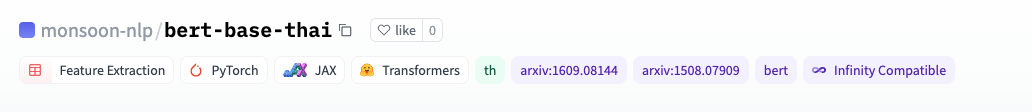

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import numpy as np
raw_datasets = load_dataset("wongnai_reviews")
checkpoint = "monsoon-nlp/bert-base-thai"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset["review_body"],
        padding="max_length",
        max_length=128,
        truncation=True,
    )
    return encoded.data

tokenized_datasets = raw_datasets.map(tokenize_dataset, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))
small_train_dataset = small_train_dataset.rename_column("star_rating", "label")
small_eval_dataset = small_eval_dataset.rename_column("star_rating", "label")

Using custom data configuration default
Reusing dataset wongnai_reviews (/root/.cache/huggingface/datasets/wongnai_reviews/default/1.0.1/0741f812b51dea635d957a5cc8f46fcc98828c0f6c557336ab20367778299a4d)


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/405 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
small_train_dataset

Dataset({
    features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [ ]:
small_eval_dataset

Dataset({
    features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5).cuda()


Downloading:   0%|          | 0.00/404M [00:00<?, ?B/s]

Some weights of the model checkpoint at monsoon-nlp/bert-base-thai were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("test_trainer")
trainer = Trainer(model=model, args=training_args, train_dataset=small_train_dataset, eval_dataset=small_eval_dataset, compute_metrics=compute_metrics, tokenizer=tokenizer)
trainer.train()


Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review_body.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 375


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=375, training_loss=1.2720508626302083, metrics={'train_runtime': 53.4781, 'train_samples_per_second': 56.098, 'train_steps_per_second': 7.012, 'total_flos': 197338606848000.0, 'train_loss': 1.2720508626302083, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review_body.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


{'epoch': 3.0,
 'eval_accuracy': 0.484,
 'eval_loss': 1.1734541654586792,
 'eval_runtime': 5.222,
 'eval_samples_per_second': 191.496,
 'eval_steps_per_second': 23.937}

In [ ]:
r = small_eval_dataset.select(range(10))

In [ ]:
r

Dataset({
    features: ['review_body', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10
})

In [ ]:
r['review_body']

['หน้าร้อนนี้เพื่อนๆ หาร้านอาหารนั่งชิลล์กันอยู่หรือเปล่าคะ พอดีวันก่อนน้องหลุมดำกับพี่ชายสุดหล่อเดินผ่านร้าน On the Table ที่สาขา Siam Center เห็นว่ามี 8 เมนูออกใหม่ “In the Summertime” เฉพาะหน้าร้อนนี้ด้วย แค่เห็นรูปก็น้ำลายไหลแล้ว รีบชวนพี่ชายเข้าร้านแบบไม่คิดมากเลยค่ะ\n\n“In the Summertime” เป็นเมนูโปรโมชันต้อนรับความอบอุ่นช่วงหน้าร้อนเท่านั้นค่ะ เห็นแต่ละเมนูเลือกไม่ได้จริงๆ ว่าจะสั่งเมนูไหน ขอลองมันทุกอย่างเลยดีกว่า อิอิ ทานไม่หมดเดี๋ยวค่อยเรียกกำลังเสริมเนอะ เมนูแรกที่เสิร์ฟที่โต๊ะของเราสองพี่น้องคือ “Bacon Double Cheese Balls” (180.-) ชีสบอลกับโปเตโตเวดจ์ทอดจนเหลืองกรอบ เพิ่มรสชาติและเทกซ์เจอร์ด้วยเบคอนกรอบ ท็อปด้วยมอลซาเรลลาชีสที่นำไปอบจนชีสละลาย เสิร์ฟมาร้อนๆ ชีสเยิ้มสุดๆ ดีงามมากกก \n\nตามด้วยโรลล์พาร์แมงโกะ “Parmango Maki” (250.-) โดดเด่นด้วยรสชาติหวานอมเปรี้ยวของมะม่วงน้ำดอกไม้ที่วางท็อปบนโรลพาร์มาแฮม ด้านในโรลล์สอดไส้ด้วยปูอัด ฮิยาชิวากาเมะ และแตงกวา รสชาติกลมกล่อมเข้ากันได้อย่างไม่น่าเชื่อ\n\nหน้าร้อนใช่ว่าต้องทานแต่ของเย็นๆ เท่านั้นนะ ทานต้มยำกุ้งแซ่บๆ หน้าร้อนก็สะใจอยู

In [ ]:
r['label']

[4, 2, 2, 3, 3, 4, 3, 1, 2, 3]

In [ ]:
preds = trainer.predict(r)

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: review_body.
***** Running Prediction *****
  Num examples = 10
  Batch size = 8


In [ ]:
preds

PredictionOutput(predictions=array([[-2.169392  , -0.53403986,  1.3838187 ,  1.7116255 ,  0.62754315],
       [-2.1685035 , -0.53458095,  1.3839552 ,  1.7116021 ,  0.62760425],
       [-2.1684787 , -0.53452617,  1.3839406 ,  1.7116442 ,  0.6276045 ],
       [-2.1688967 , -0.53413105,  1.3837498 ,  1.7117796 ,  0.6275405 ],
       [-2.1690035 , -0.53453577,  1.3839877 ,  1.7115256 ,  0.62758946],
       [-2.1683078 , -0.5345191 ,  1.3840089 ,  1.7116336 ,  0.62767285],
       [-2.1685383 , -0.53426385,  1.3838992 ,  1.7117018 ,  0.62768817],
       [-2.169358  , -0.5339462 ,  1.3835751 ,  1.7117249 ,  0.6274479 ],
       [-2.168586  , -0.53399676,  1.3837796 ,  1.7118987 ,  0.6276083 ],
       [-2.1690774 , -0.5340708 ,  1.3835826 ,  1.7118882 ,  0.6273917 ]],
      dtype=float32), label_ids=array([4, 2, 2, 3, 3, 4, 3, 1, 2, 3]), metrics={'test_loss': 1.3213870525360107, 'test_accuracy': 0.4, 'test_runtime': 0.0855, 'test_samples_per_second': 116.971, 'test_steps_per_second': 23.394})

In [ ]:
np.argmax(preds.predictions, axis=1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
# Clear everything

from keras import backend as K
K.clear_session()

from numba import cuda
cuda.select_device(0)
cuda.close()

torch.cuda.empty_cache()

!nvidia-smi

RuntimeError: ignored

## BERT (via Transformer library by Hugging Face and using Simple Transformer)
Main reasons for using simple transformers.
*   Can train the custom dataset without making formal Datasets in Huggingface's format. 
*   API is simple.

Now we can use Wongnai dataframe from the preprocessing section.


In [ ]:
! pip -q install simpletransformers

     |████████████████████████████████| 248 kB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 83.5 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 311 kB 87.1 MB/s 
     |████████████████████████████████| 1.7 MB 70.7 MB/s 
     |████████████████████████████████| 3.5 MB 92.1 MB/s 
     |████████████████████████████████| 1.2 MB 75.5 MB/s 
     |████████████████████████████████| 9.7 MB 70.7 MB/s 
     |████████████████████████████████| 895 kB 89.8 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 180 kB 55.8 MB/s 
     |████████████████████████████████| 144 kB 82.6 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 133 kB 99.3 MB/s 
     |████████████████████████████████| 243 kB 81.4 MB/s 
     |████████████████████████████████| 1.1 MB 72.6 MB/s 
     |███████████████

In [ ]:
! nvidia-smi

Mon Feb 14 08:49:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Simple transformer using a lot of conventions for simplify tasks.
# See all about the conventions >> https://github.com/ThilinaRajapakse/simpletransformers


# Simple transformer always set x class = "text" and y class = "labels" between 0..4
train_ = pd.DataFrame({"text": train["wordseged_space_review"], "labels": train["star"]-1})
test_ = pd.DataFrame({"text": test["wordseged_space_review"], "labels": test["star"]-1})
train_.labels = pd.Categorical(train_.labels)
test_.labels = pd.Categorical(test_.labels)

In [ ]:
train_

,text,labels
0,ตามที่ บอก เป็น ร้านกาแฟ ที่ เน้น ขาย เค ก นะ ...,2
1,ร้าน นี้ อยู่ ก่อน ถึง ถนน คน เดิน ค่ะ สา มา...,3
2,อู มิ ( umi ) คือ อีก หนึ่ง ร้าน ซูชิ ที่ ...,4
3,ร้าน นี้ มี สโลแกน ปลูก ผัก เพราะ รัก แม่ ...,4
4,มาตา มลาย แทง เห็น ร้าน และ การ แต่ง ก็ ตัดส...,4
...,...,...
11740,ร้าน dakasi เป็น ร้าน เค ร ื่อง ดื่ม ครับ ...,4
11741,ร้าน dakasi เป็น ร้าน เค ร ื่อง ดื่ม ครับ ...,4
11742,ร้าน dakasi เป็น ร้าน เค ร ื่อง ดื่ม ครับ ...,4
11743,ร้าน dakasi เป็น ร้าน เค ร ื่อง ดื่ม ครับ ...,4


In [ ]:
test_

,text,labels
17140,ร้าน เก่า อร่อย ราคา เบา ๆ ชอบ เนื้อ ร้า...,3
26008,ใกล้ ที่พัก เลย ลอง เดิน มา ชิม - โจ๊ก อร่...,3
1021,ร ้าน อาหาร ครัว พวง พยอม อยู่ บน เกาะ ล้าน ...,3
22522,ร้าน นี้ ญาติ ชวน มา เลี้ยง วันเกิด บอ กว่า ...,2
6108,ชาบู ราคา 299 มี หมู สไลด์ เนื้อ สไลด์ ข...,0
...,...,...
462,ร้าน อาหารทะเล แบบ พื้นๆ มี่ ไม่ มี อะไร มากมา...,4
3379,สวัสดี ค่า คราวนี้ บี จะ มา รีวิว ร้านอาหาร ...,3
8177,ร้านกาแฟ ร้าน นี้ ถ้า ใคน ได้ แวะเวียน ไป ที...,2
20896,quip sky bar ro of top แห่ง แรก บน ภ...,3


In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sklearn
model_args = {
    "reprocess_input_data": True,
    'train_batch_size':48,
    "use_early_stopping": True,
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "mcc",
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 5,
    "evaluate_during_training_steps": 500,
    "fp16": False,
    "overwrite_output_dir":True,
    'use_cached_eval_features' : False, 
    'max_seq_length': 128,
    'no_cache': True,
    "num_train_epochs": 10,
    'custom_parameter_groups':[{
        "params": ["classifier.weight", "bert.encoder.layer.10.output.dense.weight"],
        "lr": 1e-2,
    }]
}

model = ClassificationModel(
     "bert", 
     "monsoon-nlp/bert-base-thai",
     use_cuda=torch.cuda.is_available(), 
     args=model_args, 
     num_labels=5,
)

model.train_model(train_, show_running_loss = True, eval_df=test_, acc=sklearn.metrics.accuracy_score)

Downloading:   0%|          | 0.00/405 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/404M [00:00<?, ?B/s]

Some weights of the model checkpoint at monsoon-nlp/bert-base-thai were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not

Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/113 [00:00<?, ?B/s]

  0%|          | 0/11745 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 1 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/245 [00:00<?, ?it/s]

(2450, 1.2586923374935073)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(test_)

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
result

{'eval_loss': 1.8695533852577209, 'mcc': 0.07799002942987811}

In [ ]:
model_outputs

array([[-3.23202658, -1.36848235,  2.4937377 , -0.03726049,  1.58023918],
       [-2.80627394, -0.61922473,  2.64158225, -1.48237598,  1.47296214],
       [-4.10130358, -2.81355977,  1.99484658,  3.07620597,  1.78958642],
       ...,
       [-2.85398054, -0.77150166,  2.62565684, -1.24700022,  1.48986101],
       [-3.59072733, -1.96461213,  2.32922578,  1.18172276,  1.67275774],
       [-3.46963358, -1.70482969,  2.41438365,  0.6666581 ,  1.63503015]])

In [ ]:
wrong_predictions[:10]

[{'guid': 0, 'text_a': 'ร้าน เก่า   อร่อย   ราคา เบา ๆ   ชอบ เนื้อ ร้าน นี ้ อร่อย มาก   ย่าง มา กำลังดี   ที โบ น ใหญ่ เ กิน ราคา   ชอบ ขนมปัง มา กก กก   ก   อยาก จะ ขโมย สูตร มา ทำ กินที่ บ้าน   มี หลาย เมนู   ไก่ทอด ก็ อร่อย   สปา เก็ตตี้ ก็ อร่อย ดี   แต่ พอ ร์กชอพ ไม่ ไหว อย่าง แรง   จืด ๆ   แห้ง ๆ', 'text_b': None, 'label': 3},
 {'guid': 1, 'text_a': 'ใกล้ ที่พัก เลย ลอง เดิน มา ชิม   -   โจ๊ก อร่อย นะ   25   บาท เอง   ใส่ไข่ ด้วย นะ   -   ชาเย็น เข้ มดี   สีส้ม เข้ม ๆ มา เลย   หวาน มัน   -   แต่ ไข่ ตุ๋ น ไม่ อร่อย   แข็งๆ   ไม่ นิ่ม   -   ลอง มา ทาน กัน ได้   บริการ น่ารัก ประทับใจ   -   ราคา ไม่ แรง   กิน คนเดียว   85   บาท เอง   ***   โจ๊ก   25   บาท ,   ชาเย็น   15   บาท ,   ติ่มซำ   15 x 3   =   45   บาท', 'text_b': None, 'label': 3},
 {'guid': 3, 'text_a': 'ร้าน นี้ ญาติ ชวน มา เลี้ยง วันเกิด   บอ กว่า บรรยากาศ ดีมาก ๆ.   เมื่อ มาถึง ก็ สม คำ ล่ำ ลือ   ดู สบาย ตา มาก เลย   นอกจากนั้น การ ต้อนรับ และ บริการ ตั้งแต่ ก้า สู่ ร้าน จนกระทั่ง กลับ ออกมา ก็ น่าประทับใจ มาก ครับ ท

In [ ]:
len(wrong_predictions)

575

In [ ]:
model.predict(["ห่วย แตก กิน ไม่ ได้ เลย ขอ บอก อาหาร เน่า มาก กลิ่น เหม็น มี แมลง สาบ มารยาท ทราม สุด ๆ"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([1]),
 array([[ 0.66980982,  2.50308251,  1.11697662, -6.48135471,  1.03988791]]))

In [ ]:
model.predict(["ร่้าน นี้ อาหาร เยี่ยม มาก สุดยอด ประทับ ใจ ที่จอดรถ ใหญ่ ตั้งใจ ทำงาน มาก เลย"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(array([2]),
 array([[-3.32349825, -1.5388844 ,  2.40603566,  0.35282624,  1.60619223]]))

In [ ]:
model.predict(list(train_['text'][:10]))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

(array([2, 2, 2, 3, 2, 3, 1, 3, 2, 2]),
 array([[-3.38271093, -1.6558069 ,  2.40423203,  0.54542249,  1.62182927],
        [-3.71078873, -2.0812819 ,  2.30170846,  1.4662298 ,  1.69199932],
        [-3.81947613, -2.3237493 ,  2.20050216,  1.97921669,  1.72433567],
        [-4.05422878, -2.73733687,  2.019871  ,  2.91085577,  1.77773583],
        [-3.64959669, -2.09003067,  2.28378463,  1.43965161,  1.6918968 ],
        [-3.87627745, -2.4248116 ,  2.15315175,  2.21185517,  1.73708308],
        [ 1.49029207,  2.61107564,  0.5472669 , -6.60626411,  0.9546358 ],
        [-4.34053707, -3.24900365,  1.78149414,  4.09201241,  1.83582222],
        [-2.65784931, -0.35049337,  2.66001797, -1.95319188,  1.43706572],
        [-2.81356931, -0.54185307,  2.67091203, -1.60037029,  1.46593177]]))

In [ ]:
list(train_['labels'])[:10]

[2, 3, 4, 4, 4, 3, 1, 3, 2, 2]